# Time Series Classification (with Neural Networks)

The aim of this notebook is to make a binary classification of a set time series. The dataset includes 12000 time series with two types of one-day return stock market time series: Real and synthetic ones. 

Synthetic time series are created mimicking real series aiming to have a larger data set to work with. For this purpose it is crutial that synthetic and real time series present statistical properties as similar as possible, i.e. they should be indistinguishable. 

An initial analysis of moving averages and standard deviations, statistical distributions, autocorrelation for differents lags and spectral analysis led to non-significantly distinct results between the two types of series.

For this reason I will use Neural Networks (NN) to automatically detect characteristic features that allows a significant classification. 

Two different NN will be used:
1- Using the frequency spectrum of each time series to feed a fully connected neural network
2- Using the time series themselves to feed a one-dimensional convolutional NN looking for specific patterns

At the end I will create an ensemble model (stacked) of the two NN to try improve the accuracy of the classification

THE DATASET USED IN THIS NOTEBOOK IS PRIVATE AND THUS NOT PUBLICLY AVAILABLE.


In [1]:
# LOADING DATA

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Loading data
data=pd.read_csv('train.csv')
dftrain=data.drop(columns='class')
dfclass=data['class']
dftest=pd.read_csv('test.csv')    

X=dftrain.values
Y=dfclass.values

Xtest=dftest.values


In [ ]:
# Splitting the data in training set, validation set and a second validation set for the emsemble model

def TrainValTest(X,Y,rval1=0.15,rval2=0.1):

    Xtrain,Xval0,Ytrain,Yval0=train_test_split(X, Y, test_size=rval1+rval2, random_state=0)
    Xval1,Xval2,Yval1,Yval2=train_test_split(Xval0, Yval0, test_size=rval2/(rval1+rval2), random_state=0)
    
    return Xtrain,Xval1,Xval2,Ytrain,Yval1,Yval2

Xtrain,Xval,Xval2,Ytrain,Yval,Yval2=TrainValTest(X,Y,rval1=0.15,rval2=0.1)

In [47]:
#This function associates the RMS of the frequency spectrum of each time series as new features
def FreqFeatures(X):
      
    from scipy.signal import periodogram
    
    L=len(X)
    fs=1
    for i in range(L):
        f, RMS = periodogram(X[i],fs,scaling='spectrum')
        if i==0:
            Xrms=np.empty((L,len(RMS)))      
        Xrms[i]=RMS
    
    return Xrms

def NormalizationS(Xtrain,Xval,Xtest,FeatureRange=(0,1)):
    from sklearn.preprocessing import MinMaxScaler
    
    sc=MinMaxScaler(feature_range=FeatureRange)
    
    Xtrain=sc.fit_transform(Xtrain.T).T
    Xval=sc.fit_transform(Xval.T).T
    Xtest=sc.fit_transform(Xtest.T).T
    
    return Xtrain,Xval,Xtest


# Fully Connected NN using frequency spectrum

The idea here is to hopefully detect some characteristic patterns in the spectral distribution of the time series.

I have tried different configurations for different numbers of neurons and hidden layers optimizing the validation accuracy. Small NNs are not able to detect enough patterns while too complex NNs have too much parameters for the given size of the train set hence leading to overfitting

The best results are obtained with 4 hidden layers of 64,32,16 and 1 neurons and a permanent dropout of 0.5

In [49]:
from sklearn.metrics import roc_auc_score, accuracy_score

from keras.models import Sequential
from keras.layers import Dropout,Flatten,Dense
from keras import regularizers

def constructing_FullyConnected(nt,dense_params,drop):
    
    [D1,D2,D3,D4]=dense_params
    
    
    #Initializing the CNN
    classifier=Sequential()
    
    #Fully connected layers

    #First layer
    classifier.add(Dense(units=D1,input_shape=(nt,),activation='relu',kernel_regularizer=regularizers.l2(0.001)))
    #Dropout for avoiding overfitting
    classifier.add(Dropout(rate=drop))
    
    #Second layer
    classifier.add(Dense(units=D2,activation='relu',kernel_regularizer=regularizers.l2(0.001)))
#    #Dropout for avoiding overfitting
    classifier.add(Dropout(rate=drop))
    
    #Third layer
    classifier.add(Dense(units=D3,activation='relu'))#,kernel_regularizer=regularizers.l2(0.001)))
#    #Dropout for avoiding overfitting
    classifier.add(Dropout(rate=drop))
    
    #Final layer
    classifier.add(Dense(units=1,activation='sigmoid'))
    
    
    #compiling the ANN
    classifier.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
 
    classifier.summary()

    return classifier

In [50]:
def PlotLearning(history):
    
    #print(history.history.keys())
    # summarize history for accuracy
    plt.subplot(211)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.grid()
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.subplot(212)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.grid()
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 64)                8448      
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_11 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_12 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 17        
Total para

8100/8100 [==============================] - 0s 9us/step - loss: 0.6901 - acc: 0.5699 - val_loss: 0.6965 - val_acc: 0.5211
Epoch 52/130
8100/8100 [==============================] - 0s 8us/step - loss: 0.6896 - acc: 0.5699 - val_loss: 0.6961 - val_acc: 0.5244
Epoch 53/130
8100/8100 [==============================] - 0s 7us/step - loss: 0.6877 - acc: 0.5794 - val_loss: 0.6959 - val_acc: 0.5300
Epoch 54/130
8100/8100 [==============================] - 0s 7us/step - loss: 0.6878 - acc: 0.5700 - val_loss: 0.6957 - val_acc: 0.5367
Epoch 55/130
8100/8100 [==============================] - 0s 6us/step - loss: 0.6852 - acc: 0.5754 - val_loss: 0.6964 - val_acc: 0.5233
Epoch 56/130
8100/8100 [==============================] - 0s 6us/step - loss: 0.6877 - acc: 0.5672 - val_loss: 0.6964 - val_acc: 0.5211
Epoch 57/130
8100/8100 [==============================] - 0s 6us/step - loss: 0.6855 - acc: 0.5752 - val_loss: 0.6963 - val_acc: 0.5233
Epoch 58/130
8100/8100 [==============================] - 0s 

8100/8100 [==============================] - 0s 7us/step - loss: 0.5782 - acc: 0.7231 - val_loss: 0.7202 - val_acc: 0.5922
Epoch 112/130
8100/8100 [==============================] - 0s 6us/step - loss: 0.5773 - acc: 0.7236 - val_loss: 0.7294 - val_acc: 0.5767
Epoch 113/130
8100/8100 [==============================] - 0s 6us/step - loss: 0.5794 - acc: 0.7256 - val_loss: 0.7198 - val_acc: 0.5933
Epoch 114/130
8100/8100 [==============================] - 0s 6us/step - loss: 0.5789 - acc: 0.7227 - val_loss: 0.7229 - val_acc: 0.5644
Epoch 115/130
8100/8100 [==============================] - 0s 7us/step - loss: 0.5702 - acc: 0.7283 - val_loss: 0.7190 - val_acc: 0.5878
Epoch 116/130
8100/8100 [==============================] - 0s 7us/step - loss: 0.5734 - acc: 0.7251 - val_loss: 0.7220 - val_acc: 0.5778
Epoch 117/130
8100/8100 [==============================] - 0s 7us/step - loss: 0.5784 - acc: 0.7257 - val_loss: 0.7282 - val_acc: 0.5889
Epoch 118/130
8100/8100 [==============================

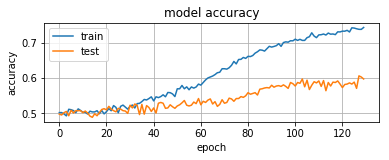

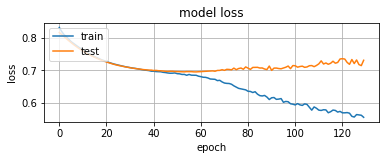

In [51]:
Xtrain_FC=FreqFeatures(Xtrain)
Xval_FC=FreqFeatures(Xval)
Xval2_FC=FreqFeatures(Xval2)
Xtest_FC=FreqFeatures(Xtest)

Xtrain_FC,Xval_FC,Xtest_FC=NormalizationS(Xtrain_FC,Xval_FC,Xtest_FC,FeatureRange=(0,1))

#Fully connected layers number of neurons
D1=64 #Neurons first layer
D2=32 #Neurons second layer
D3=16 #Neurons third layer
D4=1 #Neurons of final layer

dense_params=[D1,D2,D3,D4]

#Dropout
drop=0.5

ni,nt=Xtrain_FC.shape

FCmodel=constructing_FullyConnected(nt,dense_params,drop)

#Training!  
history=FCmodel.fit(Xtrain_FC, Ytrain, batch_size = 1024, epochs = 130,validation_split=0.1)
PlotLearning(history)

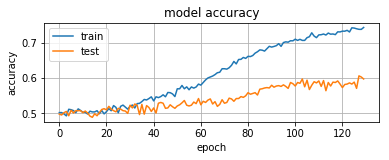

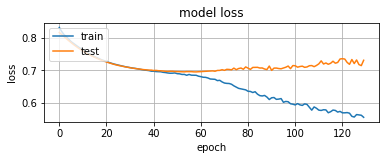

AUC for fully connected model using frequency spectrum
0.6419278763538163


In [52]:
#Plot learning rate
PlotLearning(history)

#Making validation prediction
Yvalpred_FC=FCmodel.predict(Xval_FC)

AUCval_FC=roc_auc_score(Yval,Yvalpred_FC)
print('AUC for fully connected model using frequency spectrum')
print(AUCval_FC)

# One-dimensional Convolutional NN directly using the original time series 

The idea here is using one dimensional filters to detect specific patterns that can finally lead to a good classification. Convolutional NNs automatically are commonly used in detecting micro and macro patterns in 2dim images but they can equally used in 1dim problems such as time series.

After an initial set of convolutional layers that leads for the characteristic features, a set of fully connected layers is deploy to classify the time series.

After several tries, the best results are obtained with the next configuration:
1- Three layers of CNN with 16,32 and 16 neurons. Using 4-size filters and 4-size maxpooling
2- Three layers of Fully connected NN with 32,16 and 1 neurons
3- Dropout of 0.5 is used before all FC layers 

In [53]:
#Creating test prediction
Ytestpred_FC=FCmodel.predict(Xtest_FC)

dfprediction=pd.Series(Ytestpred_FC.flatten())
dfprediction.to_csv('JesusPena11.csv',index=False)

In [54]:
from sklearn.metrics import roc_auc_score, accuracy_score

from keras.models import Sequential
from keras.layers import Conv1D,MaxPooling1D,Dropout,Flatten,Dense
from keras.utils.np_utils import to_categorical
from keras import regularizers

#Construction of the CNN with several convolutional layers plus several fully 
#connected layers
def constructing_CNN(nt,conv_params,dense_params,drop):
    
    [(nC1,dC1,pC1),(nC2,dC2,pC2),(nC3,dC3,pC3)]=conv_params
    [D1,D2,D3]=dense_params
    
    #Initializing the CNN
    classifier=Sequential()
    
    #Adding layers. 
    
    #Convolutions
    ##Data format for channels_last is (steps, features)
    classifier.add(Conv1D(nC1,dC1,input_shape=(nt,1),activation='relu',data_format='channels_last'))
    #Pooling
    classifier.add(MaxPooling1D(pool_size=pC1))
    
#    #Second CNV layer
    classifier.add(Conv1D(nC2,dC2,activation='relu'))
    #Pooling. 
    classifier.add(MaxPooling1D(pool_size=pC2))
    
    ##Third CNV layer
    classifier.add(Conv1D(nC3,dC3,activation='relu'))
    #Pooling. 
    classifier.add(MaxPooling1D(pool_size=pC3))
    
    #Flatten
    classifier.add(Flatten())
    
    #Dropout for avoiding overfitting
    classifier.add(Dropout(rate=drop))
    
#    #Fully connected layers
#    #First layer
    classifier.add(Dense(units=D1,activation='relu'))#,kernel_regularizer=regularizers.l2(0.001)))
#    #Dropout for avoiding overfitting
    classifier.add(Dropout(rate=drop))
    
    #Second layer
    classifier.add(Dense(units=D2,activation='relu'))#,kernel_regularizer=regularizers.l2(0.001)))
    #Dropout for avoiding overfitting
    classifier.add(Dropout(rate=drop))
    
    #Final layer
    classifier.add(Dense(units=D3,activation='sigmoid'))
    
    #compiling the CNN model
    classifier.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    #classifier.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])

    classifier.summary()

    return classifier


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 257, 16)           80        
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 64, 16)            0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 61, 32)            2080      
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 15, 32)            0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 12, 16)            2064      
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 6, 16)             0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 96)                0         
__________

8100/8100 [==============================] - 1s 141us/step - loss: 0.6926 - acc: 0.5174 - val_loss: 0.6926 - val_acc: 0.5511
Epoch 46/300
8100/8100 [==============================] - 1s 136us/step - loss: 0.6924 - acc: 0.5128 - val_loss: 0.6921 - val_acc: 0.5700
Epoch 47/300
8100/8100 [==============================] - 1s 128us/step - loss: 0.6921 - acc: 0.5190 - val_loss: 0.6917 - val_acc: 0.5656
Epoch 48/300
8100/8100 [==============================] - 1s 131us/step - loss: 0.6926 - acc: 0.5060 - val_loss: 0.6924 - val_acc: 0.5144
Epoch 49/300
8100/8100 [==============================] - 1s 129us/step - loss: 0.6926 - acc: 0.5172 - val_loss: 0.6920 - val_acc: 0.5011
Epoch 50/300
8100/8100 [==============================] - 1s 133us/step - loss: 0.6923 - acc: 0.5153 - val_loss: 0.6916 - val_acc: 0.5511
Epoch 51/300
8100/8100 [==============================] - 1s 129us/step - loss: 0.6914 - acc: 0.5367 - val_loss: 0.6909 - val_acc: 0.5544
Epoch 52/300
8100/8100 [=======================

8100/8100 [==============================] - 1s 131us/step - loss: 0.6401 - acc: 0.6500 - val_loss: 0.6488 - val_acc: 0.6267
Epoch 105/300
8100/8100 [==============================] - 1s 130us/step - loss: 0.6341 - acc: 0.6574 - val_loss: 0.6484 - val_acc: 0.6300
Epoch 106/300
8100/8100 [==============================] - 1s 129us/step - loss: 0.6413 - acc: 0.6417 - val_loss: 0.6468 - val_acc: 0.6389
Epoch 107/300
8100/8100 [==============================] - 1s 129us/step - loss: 0.6322 - acc: 0.6504 - val_loss: 0.6481 - val_acc: 0.6267
Epoch 108/300
8100/8100 [==============================] - 1s 129us/step - loss: 0.6372 - acc: 0.6454 - val_loss: 0.6466 - val_acc: 0.6344
Epoch 109/300
8100/8100 [==============================] - 1s 133us/step - loss: 0.6413 - acc: 0.6380 - val_loss: 0.6459 - val_acc: 0.6278
Epoch 110/300
8100/8100 [==============================] - 1s 131us/step - loss: 0.6384 - acc: 0.6451 - val_loss: 0.6492 - val_acc: 0.6289
Epoch 111/300
8100/8100 [================

8100/8100 [==============================] - 1s 139us/step - loss: 0.5891 - acc: 0.6979 - val_loss: 0.6340 - val_acc: 0.6511
Epoch 164/300
8100/8100 [==============================] - 1s 166us/step - loss: 0.5901 - acc: 0.7019 - val_loss: 0.6397 - val_acc: 0.6489
Epoch 165/300
8100/8100 [==============================] - 1s 163us/step - loss: 0.5803 - acc: 0.7059 - val_loss: 0.6332 - val_acc: 0.6633
Epoch 166/300
8100/8100 [==============================] - 1s 146us/step - loss: 0.5817 - acc: 0.7049 - val_loss: 0.6555 - val_acc: 0.6267
Epoch 167/300
8100/8100 [==============================] - 1s 167us/step - loss: 0.5828 - acc: 0.7035 - val_loss: 0.6388 - val_acc: 0.6589
Epoch 168/300
8100/8100 [==============================] - 1s 167us/step - loss: 0.5819 - acc: 0.7116 - val_loss: 0.6323 - val_acc: 0.6678
Epoch 169/300
8100/8100 [==============================] - 1s 173us/step - loss: 0.5788 - acc: 0.7109 - val_loss: 0.6389 - val_acc: 0.6567
Epoch 170/300
8100/8100 [================

8100/8100 [==============================] - 1s 141us/step - loss: 0.5645 - acc: 0.7219 - val_loss: 0.6557 - val_acc: 0.6467
Epoch 223/300
8100/8100 [==============================] - 1s 157us/step - loss: 0.5580 - acc: 0.7298 - val_loss: 0.6452 - val_acc: 0.6589
Epoch 224/300
8100/8100 [==============================] - 1s 134us/step - loss: 0.5618 - acc: 0.7254 - val_loss: 0.6471 - val_acc: 0.6467
Epoch 225/300
8100/8100 [==============================] - 1s 138us/step - loss: 0.5644 - acc: 0.7264 - val_loss: 0.6526 - val_acc: 0.6400
Epoch 226/300
8100/8100 [==============================] - 1s 137us/step - loss: 0.5533 - acc: 0.7320 - val_loss: 0.6352 - val_acc: 0.6656
Epoch 227/300
8100/8100 [==============================] - 1s 137us/step - loss: 0.5529 - acc: 0.7360 - val_loss: 0.6439 - val_acc: 0.6444
Epoch 228/300
8100/8100 [==============================] - 1s 133us/step - loss: 0.5463 - acc: 0.7406 - val_loss: 0.6505 - val_acc: 0.6478
Epoch 229/300
8100/8100 [================

8100/8100 [==============================] - 1s 143us/step - loss: 0.5244 - acc: 0.7580 - val_loss: 0.6722 - val_acc: 0.6400
Epoch 282/300
8100/8100 [==============================] - 1s 134us/step - loss: 0.5339 - acc: 0.7509 - val_loss: 0.6534 - val_acc: 0.6578
Epoch 283/300
8100/8100 [==============================] - 1s 133us/step - loss: 0.5205 - acc: 0.7533 - val_loss: 0.6568 - val_acc: 0.6467
Epoch 284/300
8100/8100 [==============================] - 1s 132us/step - loss: 0.5356 - acc: 0.7441 - val_loss: 0.6644 - val_acc: 0.6378
Epoch 285/300
8100/8100 [==============================] - 1s 133us/step - loss: 0.5423 - acc: 0.7394 - val_loss: 0.6569 - val_acc: 0.6333
Epoch 286/300
8100/8100 [==============================] - 1s 166us/step - loss: 0.5409 - acc: 0.7412 - val_loss: 0.6745 - val_acc: 0.6356
Epoch 287/300
8100/8100 [==============================] - 1s 150us/step - loss: 0.5272 - acc: 0.7467 - val_loss: 0.6424 - val_acc: 0.6522
Epoch 288/300
8100/8100 [================

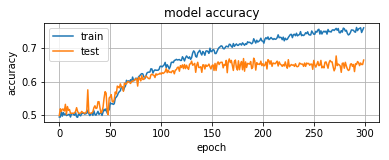

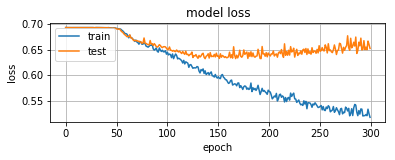

In [55]:
#Preparing data for correct dimensions
Xtrain_CNN=np.expand_dims(Xtrain,axis=2)
Xval_CNN=np.expand_dims(Xval,axis=2)
Xval2_CNN=np.expand_dims(Xval2,axis=2)
Xtest_CNN=np.expand_dims(Xtest,axis=2)

ni,nt,nf=Xtrain_CNN.shape

#Constructing the CNN model

#Convolutional layers parameters
#First layer:
nC1=16 #Number of filters
dC1=4 #Dimension of filters
pC1=4 #Maxpooling dimensions

#Second layer:
nC2=32 #Number of filters
dC2=4 #Dimension of filters
pC2=4 #Maxpooling dimensions

#Third layer:
nC3=16 #Number of filters
dC3=4 #Dimension of filters
pC3=2 #Maxpooling dimensions

conv_params=[(nC1,dC1,pC1),(nC2,dC2,pC2),(nC3,dC3,pC3)]

#Fully connected layers number of neurons
D1=32 #Neurons first layer
D2=16 #Neurons second layer
D3=1 #Neurons third layer

#Dropout ration
drop=0.5

dense_params=[D1,D2,D3]

CNNmodel=constructing_CNN(nt,conv_params,dense_params,drop)

#Training!  
history=CNNmodel.fit(Xtrain_CNN, Ytrain, batch_size = 1024, epochs = 300,validation_split=0.1)
PlotLearning(history)


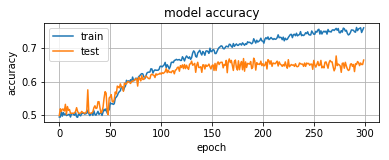

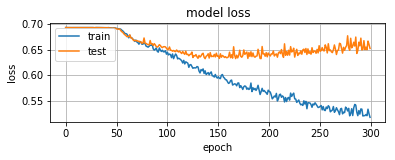

AUC for the convolutional model using frequency spectrum
0.6735151722544723


In [56]:
#Plot learning rate
PlotLearning(history)

#Making validation prediction
Yvalpred_CNN=CNNmodel.predict(Xval_CNN)

AUCval_CNN=roc_auc_score(Yval,Yvalpred_CNN)
print('AUC for the convolutional model using frequency spectrum')
print(AUCval_CNN)

In [57]:
#Creating test prediction
Ytestpred_CNN=CNNmodel.predict(Xtest_CNN)

dfprediction_CNN=pd.Series(Ytestpred_CNN.flatten())
dfprediction.to_csv('JesusPena22.csv',index=False)

# Ensemble model

To try to combine and improve the previous result, an ensemble model is created using several classical classification algorithms and a fully connected NN.

The idea of an ensemble model is to use the predicted classification of several algorithms (in this case the FCmodel and the CNNmodel) as new features to fit a new classification model that now will learn base on the previous predictions in wich cases those models were right or wrong.

In [121]:
# New features for the new model will be the class predictions of the initial models (base learners)

Yval2pred_FC=FCmodel.predict(Xval2_FC)
Yval2pred_CNN=CNNmodel.predict(Xval2_CNN)


XtrainE=np.concatenate([Yvalpred_FC,Yvalpred_CNN],axis=1)
XvalE=np.concatenate([Yval2pred_FC,Yval2pred_CNN],axis=1)

YtrainE=Yval
YvalE=Yval2


In [124]:
# Fist try with classical classification algorithms

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.model_selection import cross_validate

Emodel=RandomForestClassifier(n_estimators=1000,verbose=1)
#Emodel=GradientBoostingClassifier(n_estimators=20)
#Emodel=LogisticRegression()
#Emodel=SGDClassifier()
#Emodel=SVC()

Emodel.fit(XtrainE,YtrainE)

score_trainE=Emodel.score(XtrainE,YtrainE)
score_valE=Emodel.score(XvalE,YvalE)

print(score_trainE)
print(score_valE)

[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.4s finished


1.0
0.5833333333333334


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.3s finished


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_122 (Dense)            (None, 4)                 12        
_________________________________________________________________
dropout_88 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_123 (Dense)            (None, 4)                 20        
_________________________________________________________________
dropout_89 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_124 (Dense)            (None, 1)                 5         
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________
Train on 1620 samples, validate on 180 samples
Epoch 1/1000
1620/1620 [==============================] - 3s 2ms/step - loss: 0.7535 - acc: 0.5080 

1620/1620 [==============================] - 0s 10us/step - loss: 0.7122 - acc: 0.4883 - val_loss: 0.6850 - val_acc: 0.5667
Epoch 54/1000
1620/1620 [==============================] - 0s 10us/step - loss: 0.6965 - acc: 0.5191 - val_loss: 0.6850 - val_acc: 0.5722
Epoch 55/1000
1620/1620 [==============================] - 0s 9us/step - loss: 0.7151 - acc: 0.4778 - val_loss: 0.6849 - val_acc: 0.5778
Epoch 56/1000
1620/1620 [==============================] - 0s 10us/step - loss: 0.7115 - acc: 0.4858 - val_loss: 0.6849 - val_acc: 0.5722
Epoch 57/1000
1620/1620 [==============================] - 0s 9us/step - loss: 0.7061 - acc: 0.4907 - val_loss: 0.6849 - val_acc: 0.5722
Epoch 58/1000
1620/1620 [==============================] - 0s 9us/step - loss: 0.6982 - acc: 0.5123 - val_loss: 0.6849 - val_acc: 0.5778
Epoch 59/1000
1620/1620 [==============================] - 0s 9us/step - loss: 0.7024 - acc: 0.5105 - val_loss: 0.6848 - val_acc: 0.5778
Epoch 60/1000
1620/1620 [===========================

Epoch 113/1000
1620/1620 [==============================] - 0s 9us/step - loss: 0.6915 - acc: 0.5315 - val_loss: 0.6829 - val_acc: 0.6444
Epoch 114/1000
1620/1620 [==============================] - 0s 9us/step - loss: 0.6867 - acc: 0.5531 - val_loss: 0.6828 - val_acc: 0.6444
Epoch 115/1000
1620/1620 [==============================] - 0s 9us/step - loss: 0.6862 - acc: 0.5389 - val_loss: 0.6828 - val_acc: 0.6500
Epoch 116/1000
1620/1620 [==============================] - 0s 8us/step - loss: 0.6954 - acc: 0.5278 - val_loss: 0.6828 - val_acc: 0.6500
Epoch 117/1000
1620/1620 [==============================] - 0s 9us/step - loss: 0.6864 - acc: 0.5389 - val_loss: 0.6828 - val_acc: 0.6500
Epoch 118/1000
1620/1620 [==============================] - 0s 9us/step - loss: 0.6835 - acc: 0.5463 - val_loss: 0.6827 - val_acc: 0.6500
Epoch 119/1000
1620/1620 [==============================] - 0s 9us/step - loss: 0.6882 - acc: 0.5420 - val_loss: 0.6827 - val_acc: 0.6500
Epoch 120/1000
1620/1620 [========

1620/1620 [==============================] - 0s 9us/step - loss: 0.6826 - acc: 0.5735 - val_loss: 0.6795 - val_acc: 0.6778
Epoch 173/1000
1620/1620 [==============================] - 0s 8us/step - loss: 0.6785 - acc: 0.5630 - val_loss: 0.6795 - val_acc: 0.6778
Epoch 174/1000
1620/1620 [==============================] - 0s 8us/step - loss: 0.6869 - acc: 0.5580 - val_loss: 0.6795 - val_acc: 0.6778
Epoch 175/1000
1620/1620 [==============================] - 0s 8us/step - loss: 0.6823 - acc: 0.5728 - val_loss: 0.6794 - val_acc: 0.6778
Epoch 176/1000
1620/1620 [==============================] - 0s 8us/step - loss: 0.6811 - acc: 0.5586 - val_loss: 0.6792 - val_acc: 0.6722
Epoch 177/1000
1620/1620 [==============================] - 0s 9us/step - loss: 0.6824 - acc: 0.5691 - val_loss: 0.6791 - val_acc: 0.6778
Epoch 178/1000
1620/1620 [==============================] - 0s 8us/step - loss: 0.6947 - acc: 0.5432 - val_loss: 0.6791 - val_acc: 0.6778
Epoch 179/1000
1620/1620 [=======================

1620/1620 [==============================] - 0s 9us/step - loss: 0.6813 - acc: 0.5642 - val_loss: 0.6767 - val_acc: 0.6722
Epoch 232/1000
1620/1620 [==============================] - 0s 10us/step - loss: 0.6735 - acc: 0.5840 - val_loss: 0.6765 - val_acc: 0.6667
Epoch 233/1000
1620/1620 [==============================] - 0s 9us/step - loss: 0.6777 - acc: 0.5784 - val_loss: 0.6763 - val_acc: 0.6667
Epoch 234/1000
1620/1620 [==============================] - 0s 9us/step - loss: 0.6794 - acc: 0.5722 - val_loss: 0.6761 - val_acc: 0.6667
Epoch 235/1000
1620/1620 [==============================] - 0s 9us/step - loss: 0.6713 - acc: 0.5833 - val_loss: 0.6758 - val_acc: 0.6611
Epoch 236/1000
1620/1620 [==============================] - 0s 8us/step - loss: 0.6827 - acc: 0.5642 - val_loss: 0.6757 - val_acc: 0.6611
Epoch 237/1000
1620/1620 [==============================] - 0s 9us/step - loss: 0.6857 - acc: 0.5673 - val_loss: 0.6756 - val_acc: 0.6611
Epoch 238/1000
1620/1620 [======================

1620/1620 [==============================] - 0s 9us/step - loss: 0.6779 - acc: 0.5747 - val_loss: 0.6763 - val_acc: 0.6611
Epoch 291/1000
1620/1620 [==============================] - 0s 9us/step - loss: 0.6797 - acc: 0.5667 - val_loss: 0.6763 - val_acc: 0.6611
Epoch 292/1000
1620/1620 [==============================] - 0s 11us/step - loss: 0.6763 - acc: 0.5827 - val_loss: 0.6762 - val_acc: 0.6611
Epoch 293/1000
1620/1620 [==============================] - 0s 12us/step - loss: 0.6791 - acc: 0.5636 - val_loss: 0.6761 - val_acc: 0.6611
Epoch 294/1000
1620/1620 [==============================] - 0s 8us/step - loss: 0.6735 - acc: 0.5870 - val_loss: 0.6760 - val_acc: 0.6611
Epoch 295/1000
1620/1620 [==============================] - 0s 9us/step - loss: 0.6805 - acc: 0.5722 - val_loss: 0.6759 - val_acc: 0.6556
Epoch 296/1000
1620/1620 [==============================] - 0s 10us/step - loss: 0.6801 - acc: 0.5660 - val_loss: 0.6760 - val_acc: 0.6611
Epoch 297/1000
1620/1620 [====================

1620/1620 [==============================] - 0s 8us/step - loss: 0.6723 - acc: 0.5957 - val_loss: 0.6768 - val_acc: 0.6444
Epoch 350/1000
1620/1620 [==============================] - 0s 9us/step - loss: 0.6682 - acc: 0.5870 - val_loss: 0.6769 - val_acc: 0.6389
Epoch 351/1000
1620/1620 [==============================] - 0s 9us/step - loss: 0.6762 - acc: 0.5840 - val_loss: 0.6769 - val_acc: 0.6389
Epoch 352/1000
1620/1620 [==============================] - 0s 9us/step - loss: 0.6772 - acc: 0.5852 - val_loss: 0.6769 - val_acc: 0.6333
Epoch 353/1000
1620/1620 [==============================] - 0s 9us/step - loss: 0.6858 - acc: 0.5679 - val_loss: 0.6771 - val_acc: 0.6333
Epoch 354/1000
1620/1620 [==============================] - 0s 9us/step - loss: 0.6696 - acc: 0.5963 - val_loss: 0.6772 - val_acc: 0.6333
Epoch 355/1000
1620/1620 [==============================] - 0s 9us/step - loss: 0.6800 - acc: 0.5704 - val_loss: 0.6773 - val_acc: 0.6333
Epoch 356/1000
1620/1620 [=======================

1620/1620 [==============================] - 0s 9us/step - loss: 0.6770 - acc: 0.5963 - val_loss: 0.6773 - val_acc: 0.6444
Epoch 409/1000
1620/1620 [==============================] - 0s 10us/step - loss: 0.6717 - acc: 0.5815 - val_loss: 0.6772 - val_acc: 0.6389
Epoch 410/1000
1620/1620 [==============================] - 0s 9us/step - loss: 0.6748 - acc: 0.5765 - val_loss: 0.6770 - val_acc: 0.6444
Epoch 411/1000
1620/1620 [==============================] - 0s 8us/step - loss: 0.6764 - acc: 0.5870 - val_loss: 0.6768 - val_acc: 0.6444
Epoch 412/1000
1620/1620 [==============================] - 0s 10us/step - loss: 0.6792 - acc: 0.5759 - val_loss: 0.6766 - val_acc: 0.6444
Epoch 413/1000
1620/1620 [==============================] - 0s 10us/step - loss: 0.6725 - acc: 0.5877 - val_loss: 0.6765 - val_acc: 0.6500
Epoch 414/1000
1620/1620 [==============================] - 0s 9us/step - loss: 0.6804 - acc: 0.5617 - val_loss: 0.6764 - val_acc: 0.6500
Epoch 415/1000
1620/1620 [====================

1620/1620 [==============================] - 0s 9us/step - loss: 0.6722 - acc: 0.5920 - val_loss: 0.6779 - val_acc: 0.6333
Epoch 468/1000
1620/1620 [==============================] - 0s 10us/step - loss: 0.6710 - acc: 0.5932 - val_loss: 0.6778 - val_acc: 0.6333
Epoch 469/1000
1620/1620 [==============================] - 0s 9us/step - loss: 0.6684 - acc: 0.5889 - val_loss: 0.6777 - val_acc: 0.6333
Epoch 470/1000
1620/1620 [==============================] - 0s 11us/step - loss: 0.6746 - acc: 0.5753 - val_loss: 0.6776 - val_acc: 0.6333
Epoch 471/1000
1620/1620 [==============================] - 0s 13us/step - loss: 0.6791 - acc: 0.5784 - val_loss: 0.6775 - val_acc: 0.6333
Epoch 472/1000
1620/1620 [==============================] - 0s 9us/step - loss: 0.6735 - acc: 0.5753 - val_loss: 0.6774 - val_acc: 0.6278
Epoch 473/1000
1620/1620 [==============================] - 0s 12us/step - loss: 0.6758 - acc: 0.5722 - val_loss: 0.6773 - val_acc: 0.6333
Epoch 474/1000
1620/1620 [===================

1620/1620 [==============================] - 0s 9us/step - loss: 0.6760 - acc: 0.5809 - val_loss: 0.6798 - val_acc: 0.5889
Epoch 527/1000
1620/1620 [==============================] - 0s 12us/step - loss: 0.6698 - acc: 0.5951 - val_loss: 0.6798 - val_acc: 0.5889
Epoch 528/1000
1620/1620 [==============================] - 0s 10us/step - loss: 0.6751 - acc: 0.5747 - val_loss: 0.6797 - val_acc: 0.5889
Epoch 529/1000
1620/1620 [==============================] - 0s 10us/step - loss: 0.6717 - acc: 0.5802 - val_loss: 0.6796 - val_acc: 0.5944
Epoch 530/1000
1620/1620 [==============================] - 0s 9us/step - loss: 0.6746 - acc: 0.5790 - val_loss: 0.6794 - val_acc: 0.6000
Epoch 531/1000
1620/1620 [==============================] - 0s 10us/step - loss: 0.6761 - acc: 0.5778 - val_loss: 0.6792 - val_acc: 0.6056
Epoch 532/1000
1620/1620 [==============================] - 0s 9us/step - loss: 0.6777 - acc: 0.5772 - val_loss: 0.6792 - val_acc: 0.6111
Epoch 533/1000
1620/1620 [===================

1620/1620 [==============================] - 0s 8us/step - loss: 0.6744 - acc: 0.5796 - val_loss: 0.6791 - val_acc: 0.5944
Epoch 586/1000
1620/1620 [==============================] - 0s 8us/step - loss: 0.6751 - acc: 0.5864 - val_loss: 0.6791 - val_acc: 0.5944
Epoch 587/1000
1620/1620 [==============================] - 0s 12us/step - loss: 0.6775 - acc: 0.5759 - val_loss: 0.6791 - val_acc: 0.5944
Epoch 588/1000
1620/1620 [==============================] - 0s 11us/step - loss: 0.6798 - acc: 0.5728 - val_loss: 0.6792 - val_acc: 0.5889
Epoch 589/1000
1620/1620 [==============================] - 0s 10us/step - loss: 0.6773 - acc: 0.5821 - val_loss: 0.6793 - val_acc: 0.5889
Epoch 590/1000
1620/1620 [==============================] - 0s 10us/step - loss: 0.6759 - acc: 0.5753 - val_loss: 0.6793 - val_acc: 0.5889
Epoch 591/1000
1620/1620 [==============================] - 0s 9us/step - loss: 0.6725 - acc: 0.5827 - val_loss: 0.6793 - val_acc: 0.5889
Epoch 592/1000
1620/1620 [===================

1620/1620 [==============================] - 0s 8us/step - loss: 0.6686 - acc: 0.6037 - val_loss: 0.6785 - val_acc: 0.6000
Epoch 645/1000
1620/1620 [==============================] - 0s 9us/step - loss: 0.6775 - acc: 0.5765 - val_loss: 0.6785 - val_acc: 0.6000
Epoch 646/1000
1620/1620 [==============================] - 0s 10us/step - loss: 0.6715 - acc: 0.5852 - val_loss: 0.6785 - val_acc: 0.6000
Epoch 647/1000
1620/1620 [==============================] - 0s 10us/step - loss: 0.6749 - acc: 0.5765 - val_loss: 0.6785 - val_acc: 0.6000
Epoch 648/1000
1620/1620 [==============================] - 0s 10us/step - loss: 0.6677 - acc: 0.6093 - val_loss: 0.6785 - val_acc: 0.5944
Epoch 649/1000
1620/1620 [==============================] - 0s 9us/step - loss: 0.6709 - acc: 0.5920 - val_loss: 0.6785 - val_acc: 0.6000
Epoch 650/1000
1620/1620 [==============================] - 0s 9us/step - loss: 0.6668 - acc: 0.5975 - val_loss: 0.6782 - val_acc: 0.6056
Epoch 651/1000
1620/1620 [====================

1620/1620 [==============================] - 0s 9us/step - loss: 0.6780 - acc: 0.5716 - val_loss: 0.6777 - val_acc: 0.6111
Epoch 704/1000
1620/1620 [==============================] - 0s 9us/step - loss: 0.6699 - acc: 0.5975 - val_loss: 0.6778 - val_acc: 0.6111
Epoch 705/1000
1620/1620 [==============================] - 0s 8us/step - loss: 0.6676 - acc: 0.5994 - val_loss: 0.6779 - val_acc: 0.6111
Epoch 706/1000
1620/1620 [==============================] - 0s 9us/step - loss: 0.6724 - acc: 0.5957 - val_loss: 0.6779 - val_acc: 0.6111
Epoch 707/1000
1620/1620 [==============================] - 0s 10us/step - loss: 0.6730 - acc: 0.5877 - val_loss: 0.6779 - val_acc: 0.6111
Epoch 708/1000
1620/1620 [==============================] - 0s 10us/step - loss: 0.6728 - acc: 0.5840 - val_loss: 0.6779 - val_acc: 0.6111
Epoch 709/1000
1620/1620 [==============================] - 0s 10us/step - loss: 0.6724 - acc: 0.5827 - val_loss: 0.6777 - val_acc: 0.6111
Epoch 710/1000
1620/1620 [====================

1620/1620 [==============================] - 0s 10us/step - loss: 0.6710 - acc: 0.5944 - val_loss: 0.6798 - val_acc: 0.5778
Epoch 763/1000
1620/1620 [==============================] - 0s 10us/step - loss: 0.6709 - acc: 0.5802 - val_loss: 0.6798 - val_acc: 0.5778
Epoch 764/1000
1620/1620 [==============================] - 0s 9us/step - loss: 0.6711 - acc: 0.5938 - val_loss: 0.6798 - val_acc: 0.5778
Epoch 765/1000
1620/1620 [==============================] - 0s 10us/step - loss: 0.6677 - acc: 0.5951 - val_loss: 0.6798 - val_acc: 0.5778
Epoch 766/1000
1620/1620 [==============================] - 0s 10us/step - loss: 0.6680 - acc: 0.6099 - val_loss: 0.6796 - val_acc: 0.5833
Epoch 767/1000
1620/1620 [==============================] - 0s 10us/step - loss: 0.6741 - acc: 0.5772 - val_loss: 0.6794 - val_acc: 0.5889
Epoch 768/1000
1620/1620 [==============================] - 0s 9us/step - loss: 0.6789 - acc: 0.5864 - val_loss: 0.6792 - val_acc: 0.5944
Epoch 769/1000
1620/1620 [==================

1620/1620 [==============================] - 0s 10us/step - loss: 0.6669 - acc: 0.5938 - val_loss: 0.6767 - val_acc: 0.6222
Epoch 822/1000
1620/1620 [==============================] - 0s 9us/step - loss: 0.6755 - acc: 0.5827 - val_loss: 0.6767 - val_acc: 0.6222
Epoch 823/1000
1620/1620 [==============================] - 0s 9us/step - loss: 0.6713 - acc: 0.5907 - val_loss: 0.6768 - val_acc: 0.6222
Epoch 824/1000
1620/1620 [==============================] - 0s 9us/step - loss: 0.6676 - acc: 0.5914 - val_loss: 0.6768 - val_acc: 0.6222
Epoch 825/1000
1620/1620 [==============================] - 0s 7us/step - loss: 0.6711 - acc: 0.5901 - val_loss: 0.6769 - val_acc: 0.6222
Epoch 826/1000
1620/1620 [==============================] - 0s 8us/step - loss: 0.6670 - acc: 0.5926 - val_loss: 0.6770 - val_acc: 0.6222
Epoch 827/1000
1620/1620 [==============================] - 0s 8us/step - loss: 0.6716 - acc: 0.5877 - val_loss: 0.6769 - val_acc: 0.6222
Epoch 828/1000
1620/1620 [======================

1620/1620 [==============================] - 0s 9us/step - loss: 0.6711 - acc: 0.5926 - val_loss: 0.6779 - val_acc: 0.6000
Epoch 881/1000
1620/1620 [==============================] - 0s 8us/step - loss: 0.6786 - acc: 0.5747 - val_loss: 0.6780 - val_acc: 0.5889
Epoch 882/1000
1620/1620 [==============================] - 0s 8us/step - loss: 0.6737 - acc: 0.5833 - val_loss: 0.6780 - val_acc: 0.5944
Epoch 883/1000
1620/1620 [==============================] - 0s 9us/step - loss: 0.6743 - acc: 0.5914 - val_loss: 0.6781 - val_acc: 0.5889
Epoch 884/1000
1620/1620 [==============================] - 0s 9us/step - loss: 0.6705 - acc: 0.6019 - val_loss: 0.6782 - val_acc: 0.5889
Epoch 885/1000
1620/1620 [==============================] - 0s 9us/step - loss: 0.6732 - acc: 0.5988 - val_loss: 0.6782 - val_acc: 0.5889
Epoch 886/1000
1620/1620 [==============================] - 0s 10us/step - loss: 0.6697 - acc: 0.5907 - val_loss: 0.6782 - val_acc: 0.5889
Epoch 887/1000
1620/1620 [======================

1620/1620 [==============================] - 0s 10us/step - loss: 0.6761 - acc: 0.5790 - val_loss: 0.6777 - val_acc: 0.5944
Epoch 940/1000
1620/1620 [==============================] - 0s 9us/step - loss: 0.6784 - acc: 0.5784 - val_loss: 0.6780 - val_acc: 0.5889
Epoch 941/1000
1620/1620 [==============================] - 0s 10us/step - loss: 0.6730 - acc: 0.5833 - val_loss: 0.6781 - val_acc: 0.5944
Epoch 942/1000
1620/1620 [==============================] - 0s 10us/step - loss: 0.6776 - acc: 0.5741 - val_loss: 0.6783 - val_acc: 0.5944
Epoch 943/1000
1620/1620 [==============================] - 0s 9us/step - loss: 0.6739 - acc: 0.5864 - val_loss: 0.6784 - val_acc: 0.5944
Epoch 944/1000
1620/1620 [==============================] - 0s 10us/step - loss: 0.6754 - acc: 0.5716 - val_loss: 0.6784 - val_acc: 0.5944
Epoch 945/1000
1620/1620 [==============================] - 0s 9us/step - loss: 0.6697 - acc: 0.5994 - val_loss: 0.6785 - val_acc: 0.5944
Epoch 946/1000
1620/1620 [===================

1620/1620 [==============================] - 0s 9us/step - loss: 0.6723 - acc: 0.5920 - val_loss: 0.6762 - val_acc: 0.6333
Epoch 999/1000
1620/1620 [==============================] - 0s 10us/step - loss: 0.6769 - acc: 0.5833 - val_loss: 0.6763 - val_acc: 0.6278
Epoch 1000/1000
1620/1620 [==============================] - 0s 10us/step - loss: 0.6722 - acc: 0.5901 - val_loss: 0.6763 - val_acc: 0.6222


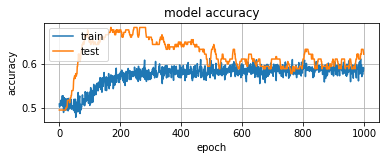

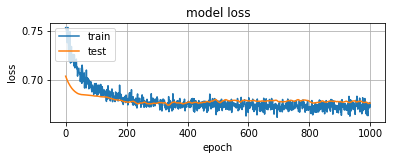

In [183]:
# Second try with a Fully Connected NN

from keras.models import Sequential
from keras.layers import Dropout,Flatten,Dense
from keras import regularizers


def constructing_FullyConnected_E(nt,dense_params,drop):
    
    [D1,D2,Df]=dense_params
    #[D1,D2,D3,Df]=dense_params

    
    #Initializing the CNN
    classifier=Sequential()
    
    #Fully connected layers

    #First layer
    classifier.add(Dense(units=D1,input_shape=(nt,),activation='relu',kernel_regularizer=regularizers.l2(0.001)))
    #Dropout for avoiding overfitting
    classifier.add(Dropout(rate=drop))
    
    #Second layer
    classifier.add(Dense(units=D2,activation='relu',kernel_regularizer=regularizers.l2(0.001)))
#    #Dropout for avoiding overfitting
    classifier.add(Dropout(rate=drop))
    
#    #Third layer
#    classifier.add(Dense(units=D3,activation='relu',kernel_regularizer=regularizers.l2(0.001)))
#    #Dropout for avoiding overfitting
#    classifier.add(Dropout(rate=drop))
    
    #Final layer
    classifier.add(Dense(units=Df,activation='sigmoid'))
    
    
    #compiling the ANN
    classifier.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
 
    classifier.summary()

    return classifier

#Fully connected layers number of neurons
D1=4 #Neurons first layer
D2=4 #Neurons second layer
#D3=2 #Neurons third layer
Df=1 #Neurons of final layer

dense_params=[D1,D2,Df]
#dense_params=[D1,D2,D3,Df]


#Dropout
drop=0.5

ni,nt=XtrainE.shape

EFCmodel=constructing_FullyConnected_E(nt,dense_params,drop)

#Training!  
history=EFCmodel.fit(XtrainE, YtrainE, batch_size = 1024, epochs = 1000,validation_split=0.1)
PlotLearning(history)

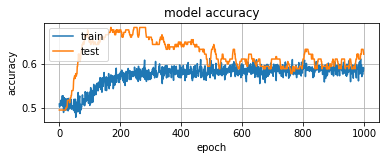

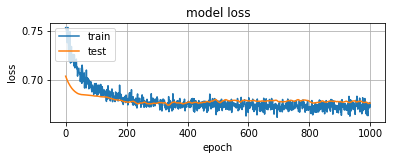

AUC for the stacked model
0.6696185267181298


In [185]:
#Plot learning rate
PlotLearning(history)

#Making validation prediction
Yvalpred_E=EFCmodel.predict(XvalE)

AUCval_E=roc_auc_score(YvalE,Yvalpred_E)
print('AUC for the stacked model')
print(AUCval_E)

# Conclusion

From the three ways (FC model, CNN model, Ensemble model) the best result is obtained with the CNN model (71% accuracy on the validation dataset). The ensemble model provides a maximum accuracy of 70-71% what does not represent an improvement besides the additional complexity. And finally the FC model provides the worst accuracy (66%) 